# Linear Regression

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import load_digits, load_wine
from scipy.stats import boxcox
from scipy.stats.mstats import normaltest

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

In [2]:
# load the data

URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/CarPrice_Assignment.csv'

data = pd.read_csv(URL)
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

<div style="color:#F5B7B1; font-size:1.3em;">

According to the output above, we have 205 entries or rows, as well as 26 features. The "Non-Null Count" column shows the number of non-null entries. If the count is 205 then there is no missing values for that particular feature. The 'price' is our target, or response variable, and the rest of the features are our predictor variables.

We also have a mix of numerical (8 int64 and 8 float64) and object data types (10 object).

The describe() function will provide the statistical information about all numeric values.

</div>

In [4]:
data.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


## Data Cleaning and Wrangling

In [5]:
# checking missing values
null_counts = data.isnull().sum()
null_cols = null_counts[null_counts != 0]
print(null_cols)

total_nulls = null_counts.sum()
print(f"Total null values: {total_nulls}")


Series([], dtype: int64)
Total null values: 0


<div style="color:#F5B7B1; font-size:1.3em;">

Also, check for any duplicates by running `duplicated()` function through 'car_ID' records, since each row has a unique car ID value.


</div>

In [6]:
sum(data.duplicated(subset = 'car_ID')) == 0

True

In [7]:
# or another way to check:
num_duplicates = data['car_ID'].duplicated().sum()
print(f"There are {num_duplicates} duplicate values in the 'car_ID' column.")

There are 0 duplicate values in the 'car_ID' column.


In [8]:
np.random.choice(data["CarName"].unique(), size=10, replace=False)

array(['nissan note', 'buick electra 225 custom', 'porsche cayenne',
       'volvo 264gl', 'audi 5000', 'volvo 244dl', 'plymouth cricket',
       'honda civic cvcc', 'subaru', 'toyota corona liftback'],
      dtype=object)

<div style="color:#F5B7B1; font-size:1.3em;">

→ We can see that the 'CarName' includes both the company name (brand) and the car model. Next, we want to split a company name from the model of a car, as for our model building purpose, we will focus on a company name only.
</div>

In [9]:
data['brand'] = data.CarName.str.split(' ').str.get(0).str.lower()
data.brand.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

<div style="color:#F5B7B1; font-size:1.3em;">

There are some typos in the names of the cars, so they should be corrected.

</div>

In [10]:
data['brand'] = data['brand'].replace(['vw', 'vokswagen'], 'volkswagen')
data['brand'] = data['brand'].replace(['maxda'], 'mazda')
data['brand'] = data['brand'].replace(['porcshce'], 'porsche')
data['brand'] = data['brand'].replace(['toyouta'], 'toyota')

In [11]:
data.brand.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

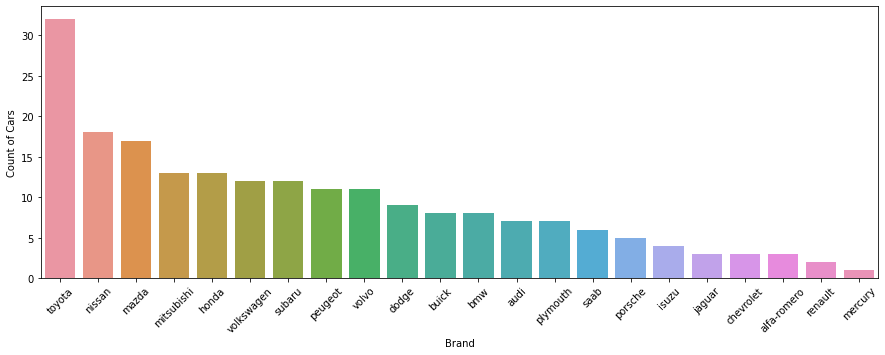

<Figure size 432x288 with 0 Axes>

In [12]:
# plot the brands:

fig, ax = plt.subplots(figsize = (15,5))
plt1 = sns.countplot(x=data['brand'], order=pd.value_counts(data['brand']).index)
plt1.set(xlabel = 'Brand', ylabel= 'Count of Cars')

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()
plt.tight_layout()



In [13]:
# drop 'car_ID', 'symboling', and 'CarName', they will no longer be needed.
data.drop(['car_ID', 'symboling', 'CarName'],axis = 1, inplace = True)

In [14]:
# exploring some other values in other columns:
print(data.fueltype.unique())
print(data["enginelocation"].value_counts())

['gas' 'diesel']
front    202
rear       3
Name: enginelocation, dtype: int64


<div style="color:#F5B7B1; font-size:1.3em;">

Group the data by 'brand', calculate the average price for each brand, and split these prices into 3 bins: 'Budget', 'Mid-Range', and 'Luxury' cars, naming the newly created column - the 'brand_category'.

</div>

In [15]:
data_comp_avg_price = data[['brand','price']].groupby('brand', as_index = False).mean().rename(columns={'price':'brand_avg_price'})

data = data.merge(data_comp_avg_price, on = 'brand')

data.brand_avg_price.describe()

count      205.000000
mean     13276.710571
std       7154.179185
min       6007.000000
25%       9239.769231
50%      10077.500000
75%      15489.090909
max      34600.000000
Name: brand_avg_price, dtype: float64

In [16]:
data['brand_category'] = data['brand_avg_price'].apply(lambda x : "Budget" if x < 10000 
                                                     else ("Mid_Range" if 10000 <= x < 20000
                                                           else "Luxury"))

## **Exploratory Data Analysis**


<div style="color:#F5B7B1; font-size:1.3em;">

List of Categorical Variables:

*   brand_category
*   fueltype
*   enginetype
*   carbody
*   doornumber
*   enginelocation
*   fuelsystem
*   cylindernumber
*   aspiration
*   drivewheel

We will use the `boxplot()` function on the above mentioned categorical variables, to display the mean, variance, and possible outliers, with respect to the price.


</div>

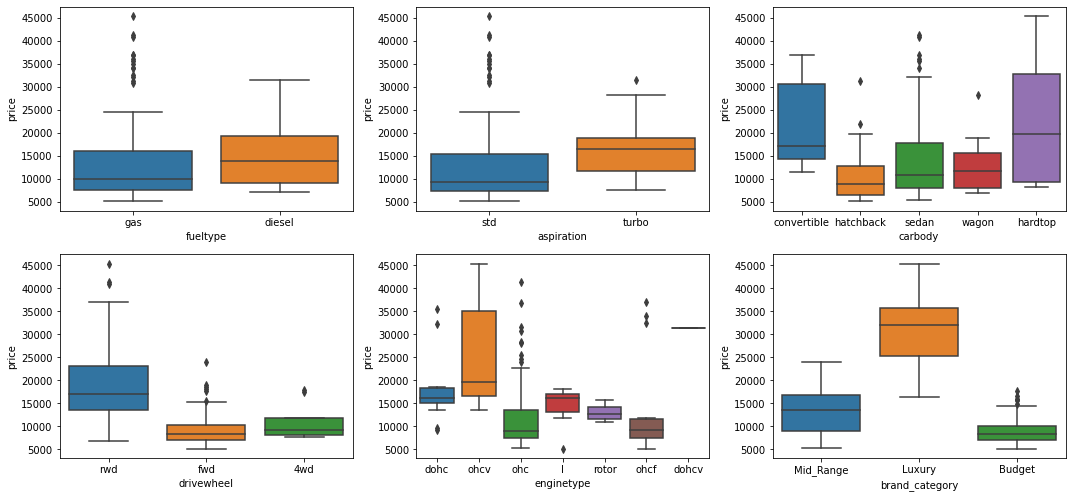

In [17]:
plt.figure(figsize=(15, 10))
plt.subplot(3,3,1)
sns.boxplot(x = 'fueltype', y = 'price', data = data)
plt.subplot(3,3,2)
sns.boxplot(x = 'aspiration', y = 'price', data = data)
plt.subplot(3,3,3)
sns.boxplot(x = 'carbody', y = 'price', data = data)
plt.subplot(3,3,4)
sns.boxplot(x = 'drivewheel', y = 'price', data = data)
plt.subplot(3,3,5)
sns.boxplot(x = 'enginetype', y = 'price', data = data)
plt.subplot(3,3,6)
sns.boxplot(x = 'brand_category', y = 'price', data = data)
plt.tight_layout()
plt.show()

<div style="color:#F5B7B1; font-size:1.3em;">

Let's view the list of top features that have high correlation coefficient. The corr() function calculates the Pearson's correlation coefficients with respect to the 'price'.

</div>

In [18]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix['price'].sort_values(ascending=False)

price               1.000000
brand_avg_price     0.895520
enginesize          0.874145
curbweight          0.835305
horsepower          0.808139
carwidth            0.759325
carlength           0.682920
wheelbase           0.577816
boreratio           0.553173
carheight           0.119336
stroke              0.079443
compressionratio    0.067984
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
Name: price, dtype: float64

<div style="color:#F5B7B1; font-size:1.3em;">

Use the `heatmap()` or `pairplot()` to further explore the relationship between all features and the target variables.

</div>

pairplot()



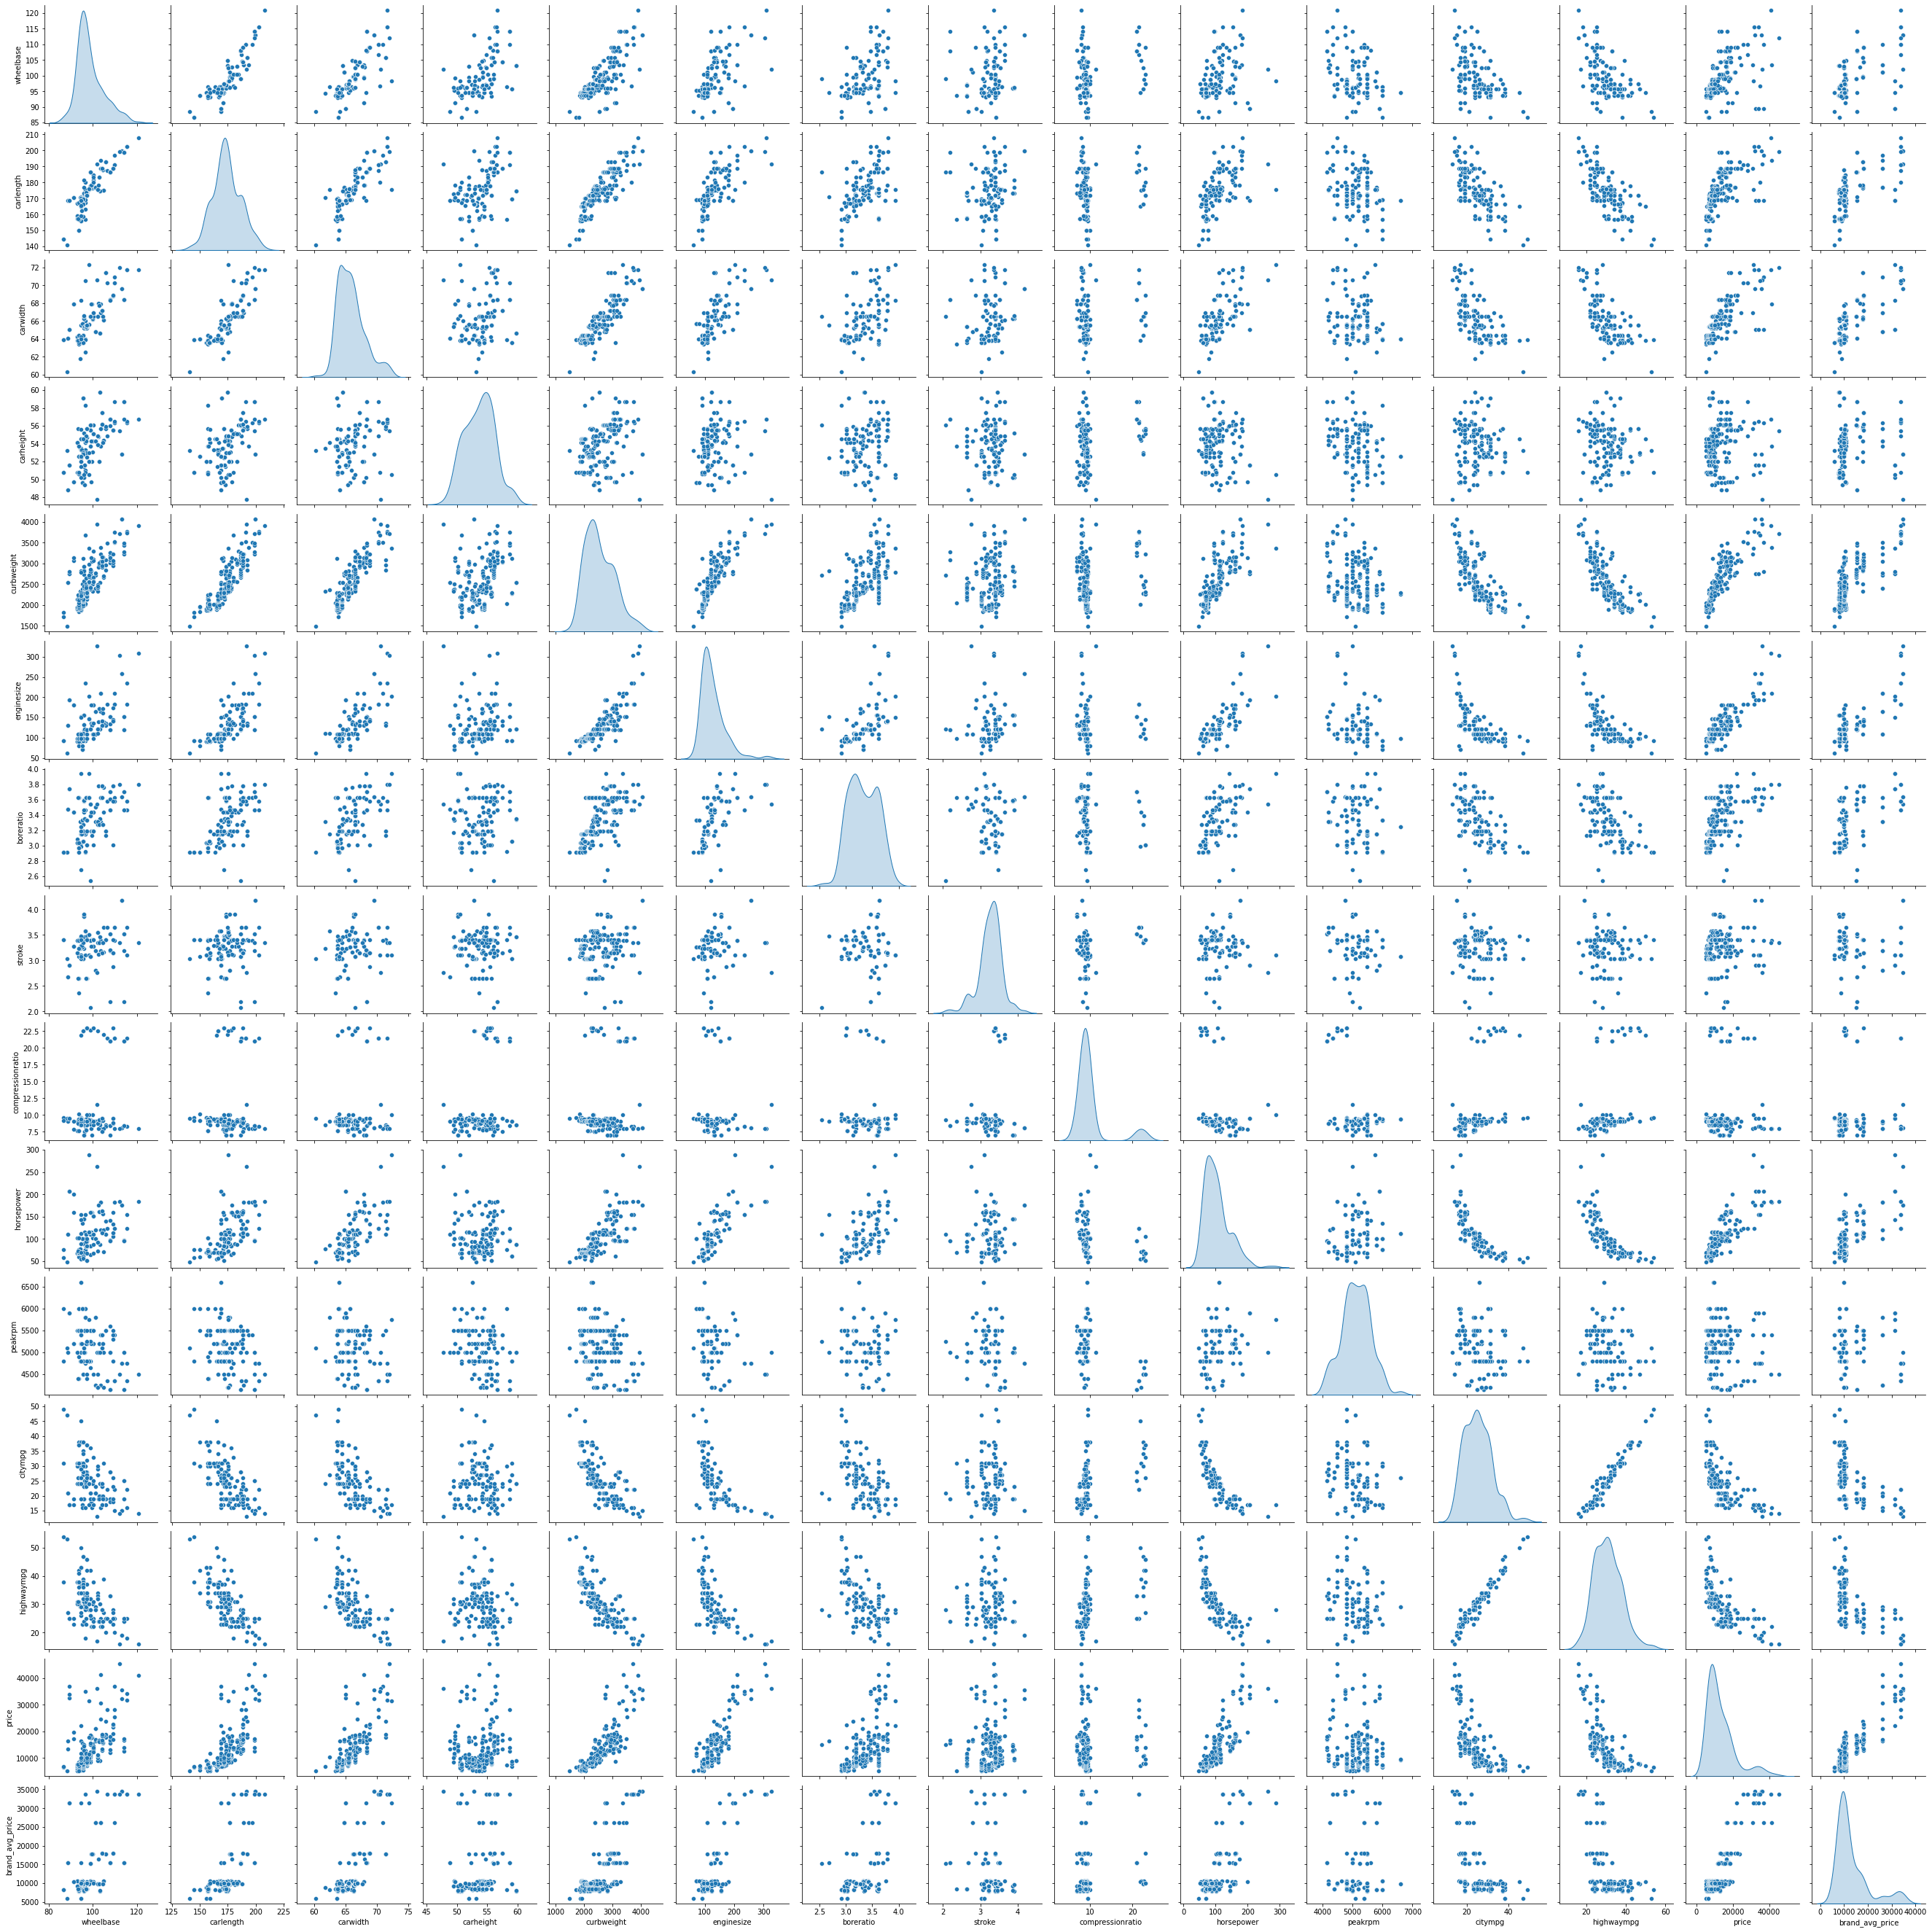

In [19]:
print("pairplot()\n")
sns.pairplot(data, diag_kind='kde');

heatmap()



<AxesSubplot: >

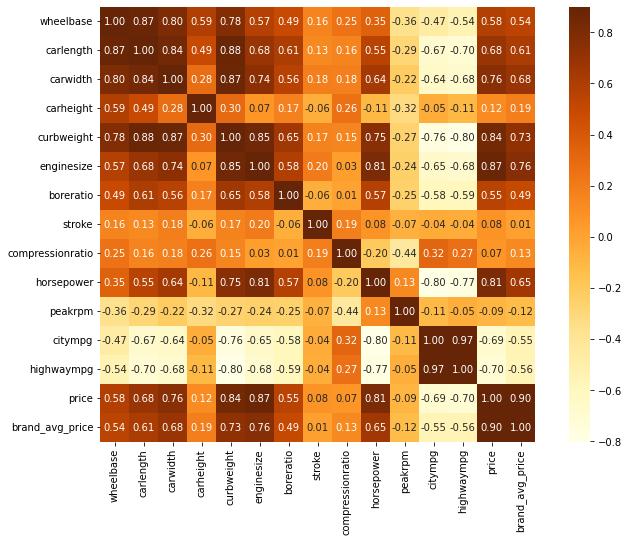

In [20]:
print("heatmap()\n")
ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr_matrix, vmax=0.9, square=True, annot=True, fmt='0.2f', cmap='YlOrBr')

## **Testing Assumptions for Linear Regression**

<div style="color:#F5B7B1; font-size:1.3em;">

Since we fit a linear model, we assume that the relationship between the target (price) and other features is linear.

We also expect that the errors, or residuals, are pure random fluctuations around the true line, in other words, the variability in the response (dependent) variable doesn't increase as the value of the predictor (independent) variable increases. This is the assumption of equal variance, also known as *Homoscedasticity*.

We also assume that the observations are independent of one another (no *multicollinearity*), and there is no correlation between the sequential observations.

If we see one of these assumptions in the dataset are not met, it's more likely that the other ones, mentioned above, will also be violated. Luckily, we can check and fix these assumptions with a few unique techniques.

</div>

### 1. Linearity Assumption
<div style="color:#F5B7B1; font-size:1.3em;">

Linear regression needs the relationship between independent variable and the dependent variable to be linear. We can test this assumption with some scatter plots and regression lines.

We will start with the 'enginesize' and 'horsepower' features.
</div>

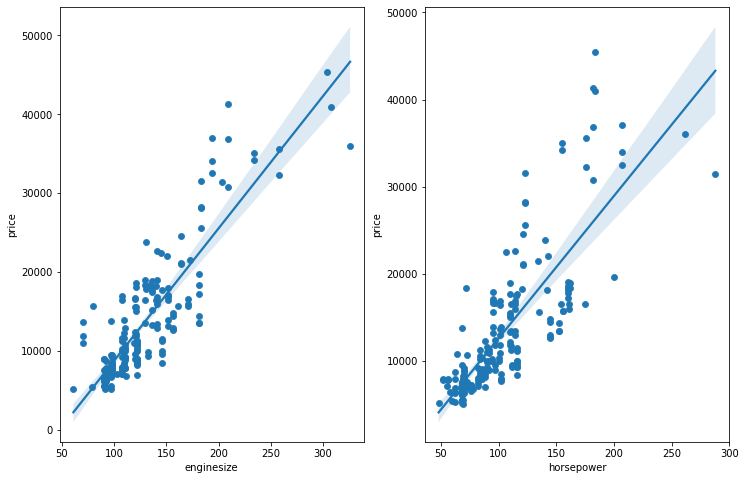

In [21]:
fig, (ax1, ax2) = plt.subplots(figsize = (12,8), ncols=2,sharey=False)
sns.scatterplot( x = data.enginesize, y = data.price,  ax=ax1)
sns.regplot(x=data.enginesize, y=data.price, ax=ax1)
 
sns.scatterplot(x = data.horsepower,y = data.price, ax=ax2)
sns.regplot(x=data.horsepower, y=data.price, ax=ax2);

<AxesSubplot: xlabel='curbweight', ylabel='price'>

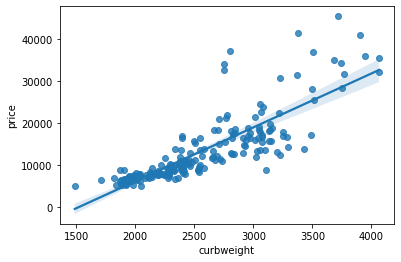

In [22]:
sns.regplot(x=data.curbweight, y=data.price, data=data)

### 2. *Homoscedasticity*

<div style="color:#F5B7B1; font-size:1.3em;">

The assumption of *homoscedasticity* (constant variance), is crucial to linear regression models. *Homoscedasticity* describes a situation in which the error term or variance or the "noise" or random disturbance in the relationship between the independent variables and the dependent variable is the same across all values of the independent variable. In other words, there is a constant variance present in the response variable as the predictor variable increases. If the "noise" is not the same across the values of an independent variable, we call it *heteroscedasticity*, opposite of *homoscedasticity*.

</div>

<AxesSubplot: xlabel='enginesize', ylabel='price'>

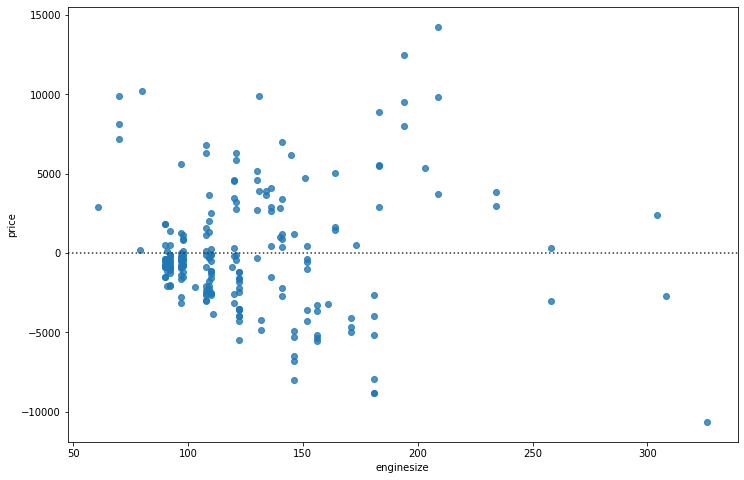

In [23]:
plt.subplots(figsize = (12,8))
sns.residplot(x=data["enginesize"], y=data["price"])

<div style="color:#F5B7B1; font-size:1.3em;">

From the above plot, we can tell the error variance across the true line is dispersed somewhat not uniformly, but in a funnel like shape. So, the assumption of the homoscedasticity is more likely not met.

</div>

### 3. Normality

<div style="color:#F5B7B1; font-size:1.3em;">

The linear regression analysis requires the dependent variable, 'price', to be normally distributed. A histogram, box plot, or a Q-Q-Plot can check if the target variable is normally distributed. The goodness of fit test, e.g., the Kolmogorov-Smirnov test can check for normality in the dependent variable.

Let's display all three charts to show how our target variable, 'price' behaves.
</div>

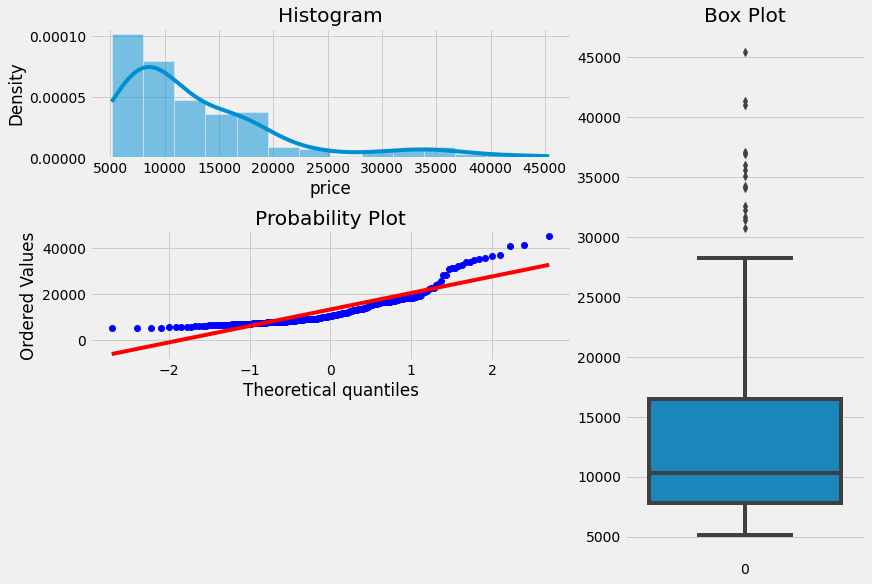

In [24]:
def plotting_3_chart(data, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.histplot(data.loc[:,feature], kde=True, stat='density', ax=ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(data.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(data.loc[:,feature], orient='v', ax = ax3);
    
plotting_3_chart(data, 'price')

<div style="color:#F5B7B1; font-size:1.3em;">

These three charts above can tell us a lot about our target variable:

*   Our target variable, 'price' is not normally distributed
*   Our target variable is right-skewed
*   There are some outliers in the variable

The right-skewed plot means that most prices in the dataset are on the lower end (below 15,000). The 'max' value is very far from the '75%' quantile statistic. All these plots show that the assumption for accurate linear regression modeling is not met.

Next, we will perform the log transformation to correct our target variable and to make it more normally distributed.

But first, we will save our data that we have changed so far, in the 'previous_data' frame.

</div>

In [25]:
previous_data = data.copy()

### Log Transformation
<div style="color:#F5B7B1; font-size:1.3em;">

We can also check statistically if the target is normally distributed, using `normaltest()` function. If the p-value is large (>0.05), the target variable is normally distributed.

</div>

In [26]:
normaltest(data.price.values)

NormaltestResult(statistic=77.37514013383584, pvalue=1.578344501676757e-17)

→ As we can see, the p-value is very small, so it is not normally distributed.

<div style="color:#F5B7B1; font-size:1.3em;">

Now, we can try to transform our data, so it looks more normally distributed. We can use the `np.log()` or `np.log1p` functions from the `numpy` library to perform the log transformation. The `np.log1p` works better with smaller numbers and thus provides more accurate results. 

</div>

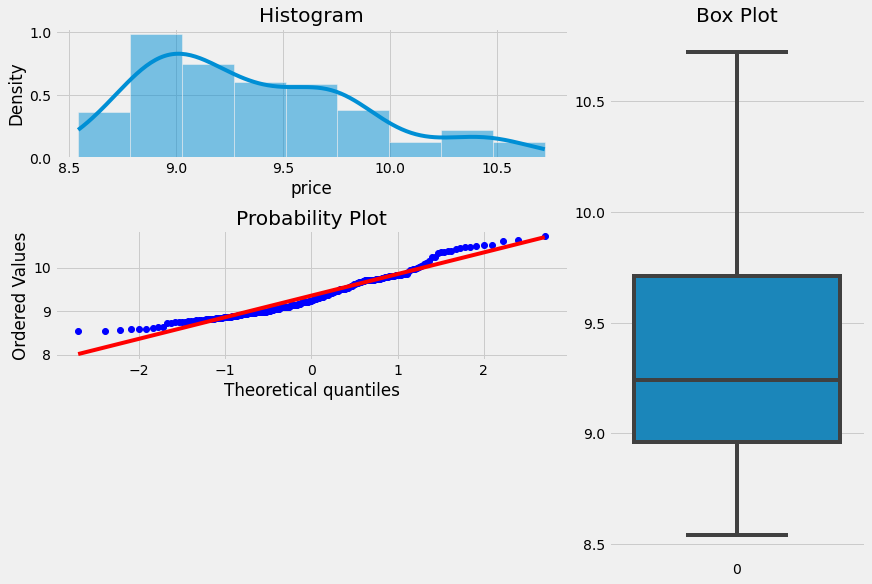

In [27]:
data['price'] = np.log(data['price'])
plotting_3_chart(data, 'price')

In [28]:
# Let's check our p-value, after the transformation.
normaltest(data.price.values)

NormaltestResult(statistic=14.10341345775947, pvalue=0.0008659297880185564)

→ As we can see, the log method transformed the car 'price' distribution into a more symmetrical bell curve. It is still not perfect, but it is much closer to being normally distributed.

> There are other ways to correct the skewed data. For example, Square Root Transform (`np.sqrt`) and the Box-Cox Transform (`stats.boxcox` from the `scipy stats` library).

<div style="color:#F5B7B1; font-size:1.3em;">

`boxcox()` function to do another transformation on the original, untransformed data (previous_data). Use the `normaltest()` function to check for statistics.

</div>

In [29]:
cp_result = boxcox(previous_data.price)
boxcox_price = cp_result[0]
print(normaltest(boxcox_price), '\n')

print(f"The higher the p-value is, the closer the distribution is to normal.\nIn our case, pvalue={normaltest(boxcox_price)[1]}, is very small,\n(<0.05), so the target variable is still not normally distributed.")

NormaltestResult(statistic=16.727142005583726, pvalue=0.00023321005129893173) 

The higher the p-value is, the closer the distribution is to normal.
In our case, pvalue=0.00023321005129893173, is very small,
(<0.05), so the target variable is still not normally distributed.


### 4. *Multicollinearity*

<div style="color:#F5B7B1; font-size:1.3em;">

*Multicollinearity* is when there is a strong correlation between the independent variables. Linear regression or multilinear regression requires independent variables to have little or no similar features. *Multicollinearity* can lead to a variety of problems, including:

*   The effect of predictor variables estimated by our regression will depend on what other variables are included in our model.
*   Predictors can have widely different results depending on the observations in our sample, and small changes in samples can   result in very different estimated effects.
*   With very high multicollinearity, the inverse matrix, the computer calculations may not be accurate.
*   We can no longer interpret a coefficient on a variable because there is no scenario in which one variable can change without a conditional change in another variable.

Using `heatmap()` function is an excellent way to identify whether there is *multicollinearity* present or not. The best way to solve for *multicollinearity* is to use the regularization methods like *Ridge* or *Lasso*, which we will introduce in the **Regularization** lab.

</div>

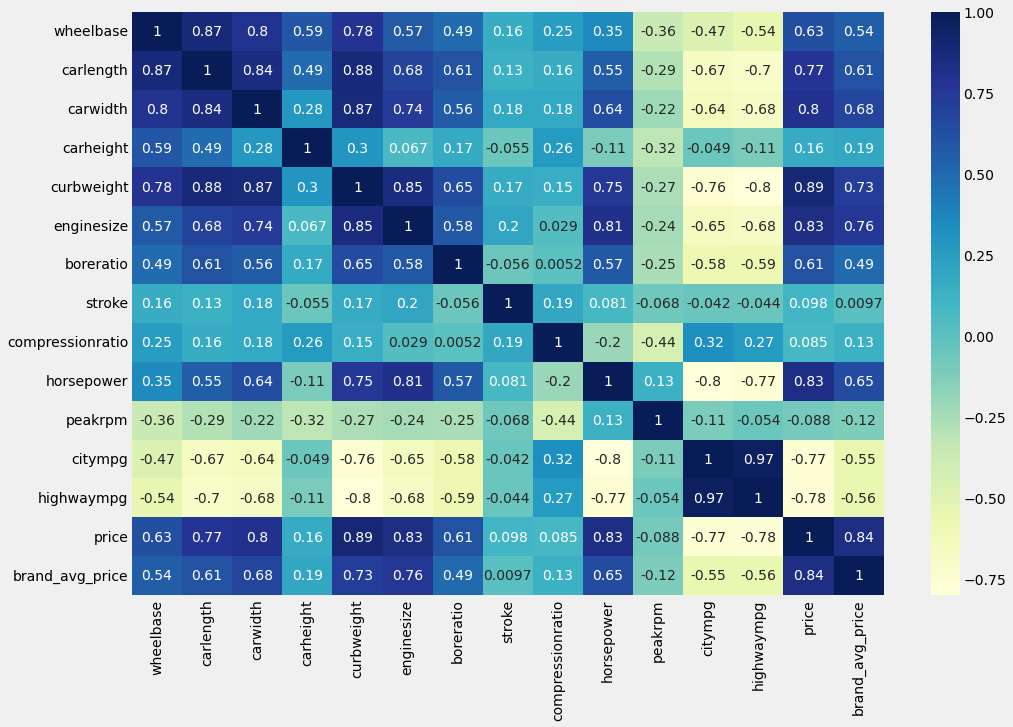

In [30]:
# heatmap again:
plt.figure(figsize = (15, 10))
sns.heatmap(data.corr(numeric_only=True), annot = True, cmap="YlGnBu") 
plt.show()

***
## **Linear Regression Model**

<div style="color:#F5B7B1; font-size:1.3em;">

List of significant variables after Exploratory Data Analysis :

Numerical:

*   Curbweight
*   Car Length
*   Car width
*   Engine Size
*   Boreratio
*   Horse Power
*   Wheel base
*   City mpg (miles per gallon)
*   Highway mpg (miles per gallon)

Categorical:

*   Engine Type
*   Fuel type
*   Car Body
*   Aspiration
*   Cylinder Number
*   Drivewheel
*   Brand Category

</div>

In [31]:
# put all the selected features into a data frame
columns=['price', 'fueltype', 'aspiration','carbody', 'drivewheel','wheelbase', 'brand_category',
         'curbweight', 'enginetype', 'cylindernumber', 
         'enginesize', 'boreratio','horsepower', 'carlength',
         'carwidth','citympg','highwaympg']

selected = data[columns]
selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           205 non-null    float64
 1   fueltype        205 non-null    object 
 2   aspiration      205 non-null    object 
 3   carbody         205 non-null    object 
 4   drivewheel      205 non-null    object 
 5   wheelbase       205 non-null    float64
 6   brand_category  205 non-null    object 
 7   curbweight      205 non-null    int64  
 8   enginetype      205 non-null    object 
 9   cylindernumber  205 non-null    object 
 10  enginesize      205 non-null    int64  
 11  boreratio       205 non-null    float64
 12  horsepower      205 non-null    int64  
 13  carlength       205 non-null    float64
 14  carwidth        205 non-null    float64
 15  citympg         205 non-null    int64  
 16  highwaympg      205 non-null    int64  
dtypes: float64(5), int64(5), object(7)


<div style="color:#F5B7B1; font-size:1.3em;">

We can find the categorical columns by  iterating  through the `dtypes`  attribute.

</div>

In [32]:
categorical_columns=[key for key, value in selected.dtypes.items()  if value=='O']
categorical_columns

['fueltype',
 'aspiration',
 'carbody',
 'drivewheel',
 'brand_category',
 'enginetype',
 'cylindernumber']

<div style="color:#F5B7B1; font-size:1.3em;">

We can find the numeric columns using the list `columns` and assign them to the list  `numeric_columns`.

</div>

In [33]:
numeric_columns=list(set(columns)-set(categorical_columns)) 
numeric_columns

['boreratio',
 'citympg',
 'horsepower',
 'curbweight',
 'carlength',
 'carwidth',
 'price',
 'enginesize',
 'wheelbase',
 'highwaympg']

<div style="color:#F5B7B1; font-size:1.3em;">

We can split the data into the features `X` and target `y`.

</div>

In [34]:
X = selected.drop("price", axis=1)
X.head()

,fueltype,aspiration,carbody,drivewheel,wheelbase,brand_category,curbweight,enginetype,cylindernumber,enginesize,boreratio,horsepower,carlength,carwidth,citympg,highwaympg
0,gas,std,convertible,rwd,88.6,Mid_Range,2548,dohc,four,130,3.47,111,168.8,64.1,21,27
1,gas,std,convertible,rwd,88.6,Mid_Range,2548,dohc,four,130,3.47,111,168.8,64.1,21,27
2,gas,std,hatchback,rwd,94.5,Mid_Range,2823,ohcv,six,152,2.68,154,171.2,65.5,19,26
3,gas,std,sedan,fwd,99.8,Mid_Range,2337,ohc,four,109,3.19,102,176.6,66.2,24,30
4,gas,std,sedan,4wd,99.4,Mid_Range,2824,ohc,five,136,3.19,115,176.6,66.4,18,22


In [35]:
y = selected["price"].copy()
y.head()

0    9.510075
1    9.711116
2    9.711116
3    9.543235
4    9.767095
Name: price, dtype: float64

<div style="color:#F5B7B1; font-size:1.3em;">

Before using one-hot encoding to deal with the categorical data, let's examine the distribution of the categorical variables:

</div>

In [36]:
for column in  categorical_columns:
    print("column name:", column)
    print("value_count:")
    print( X[column].value_counts())

column name: fueltype
value_count:
gas       185
diesel     20
Name: fueltype, dtype: int64
column name: aspiration
value_count:
std      168
turbo     37
Name: aspiration, dtype: int64
column name: carbody
value_count:
sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: carbody, dtype: int64
column name: drivewheel
value_count:
fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64
column name: brand_category
value_count:
Budget       95
Mid_Range    86
Luxury       24
Name: brand_category, dtype: int64
column name: enginetype
value_count:
ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: enginetype, dtype: int64
column name: cylindernumber
value_count:
four      159
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: cylindernumber, dtype: int64


<div style="color:#F5B7B1; font-size:1.3em;">
We see many categorical features have few or one occurrence. For example, we see `three`, `twelve` only occur once in the column `cylindernumber`. Therefore, if the components for the one-hot encoding are constructed using the training data, and the sample in the column `cylindernumber` does not include three or twelve, we will get an error. As a result, we must split the data before the transformation.   This is fine as one-hot encoding is a deterministic transform, but for other transforms, for example standardization, the parameters should be estimated using the training data, then applied to the test data.

</div>

## OneHotEncoder


In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

<div style="color:#F5B7B1; font-size:1.3em;">
<br>
To perform one-hot encoding, we use the `ColumnTransformer` class, this allows different columns or column subsets to be transformed separately.

The input is as follows:

The `transformerslist` is the number of tuples.
The list of `(name, transformer, columns)` tuples specify the transformer objects to be applied to the subsets of the data.

*   name: name of the operation that can be used later
*   `transformer`: estimator must support fit and transform, in this case we will use `OneHotEncoder()`
*   `‘drop’`: to  drop the columns
*   `‘passthrough’`: to pass them through untransformed data
*   `remainder`: specifies the columns that are not transformed are being set to `passthrough`. They are  combined in the output, and the non-specified columns are dropped.

We apply `fit_transform()` to transform the data.


</div>

In [38]:
one_hot = ColumnTransformer(transformers=[("one_hot", OneHotEncoder(), categorical_columns) ],remainder="passthrough")
X = one_hot.fit_transform(X)
type(X)

numpy.ndarray

<div style="color:#F5B7B1; font-size:1.3em;">

We see the output is a NumPy array, so let's get the feature names from the `one_hot` object using  `get_feature_names_out()` method. The output  will be the feature name with the  prefix of the name of the transformer. For one-hot encoding, the prefix will also include the name of the column that generated that feature.

</div>

In [39]:
names=one_hot.get_feature_names_out()
names

array(['one_hot__fueltype_diesel', 'one_hot__fueltype_gas',
       'one_hot__aspiration_std', 'one_hot__aspiration_turbo',
       'one_hot__carbody_convertible', 'one_hot__carbody_hardtop',
       'one_hot__carbody_hatchback', 'one_hot__carbody_sedan',
       'one_hot__carbody_wagon', 'one_hot__drivewheel_4wd',
       'one_hot__drivewheel_fwd', 'one_hot__drivewheel_rwd',
       'one_hot__brand_category_Budget', 'one_hot__brand_category_Luxury',
       'one_hot__brand_category_Mid_Range', 'one_hot__enginetype_dohc',
       'one_hot__enginetype_dohcv', 'one_hot__enginetype_l',
       'one_hot__enginetype_ohc', 'one_hot__enginetype_ohcf',
       'one_hot__enginetype_ohcv', 'one_hot__enginetype_rotor',
       'one_hot__cylindernumber_eight', 'one_hot__cylindernumber_five',
       'one_hot__cylindernumber_four', 'one_hot__cylindernumber_six',
       'one_hot__cylindernumber_three', 'one_hot__cylindernumber_twelve',
       'one_hot__cylindernumber_two', 'remainder__wheelbase',
       'remain

In [40]:
# Let's strip out the prefix of the string
colunm_names=[name[name.find("_")+1:] for name in [name[name.find("__")+2:] for name in names]]
for colnames in colunm_names:
    print(colnames, end=' | ')

diesel | gas | std | turbo | convertible | hardtop | hatchback | sedan | wagon | 4wd | fwd | rwd | category_Budget | category_Luxury | category_Mid_Range | dohc | dohcv | l | ohc | ohcf | ohcv | rotor | eight | five | four | six | three | twelve | two | wheelbase | curbweight | enginesize | boreratio | horsepower | carlength | carwidth | citympg | highwaympg | 

In [41]:
# save the result as a dataframe
df = pd.DataFrame(data=X,columns=colunm_names)
# or to .csv format directly:
# #df.to_csv('cleaned_car_data.csv', index=False)

<div style="color:#F5B7B1; font-size:1.3em;">
<br>
The same task as  `ColumnTransformer` using `OneHotEncoder()`:

</div>

In [42]:
X_ = selected[categorical_columns+numeric_columns]
X_numeric=selected[numeric_columns].to_numpy() 
X_categorical=OneHotEncoder().fit_transform(X_[categorical_columns]).toarray() 
X_ = np.concatenate((X_categorical,X_numeric), axis = 1)

<div style="color:#F5B7B1; font-size:1.3em;">
<br>
    
The lines of code that performs same task as  `ColumnTransformer` using `pd.get_dummies`:

</div>

In [43]:
def func_for_dummies(x,data):
    temp = pd.get_dummies(data[x], drop_first = True)
    data = pd.concat([data, temp], axis = 1)
    data.drop([x], axis = 1, inplace = True)
    return data

X_ = selected[categorical_columns+numeric_columns]
N_column=0

for column in  categorical_columns:
    print(pd.unique(data[column]))

X_ = func_for_dummies(column, X_)

['gas' 'diesel']
['std' 'turbo']
['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
['rwd' 'fwd' '4wd']
['Mid_Range' 'Luxury' 'Budget']
['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']
['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']


## Train Test Split


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( df, y, test_size=0.30, random_state=0)

## Standardize the Data


In [45]:
from sklearn.preprocessing import StandardScaler

ss=StandardScaler()

<div style="color:#F5B7B1; font-size:1.3em;">
<br>
    
`fit` the training data, then `transform` it:

</div>

In [46]:
X_train = ss.fit_transform(X_train)

## Linear Regression


→ Finally, we apply the `LinearRegression()` model and `fit()` our `X` and `y` data.


In [47]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

## Making Prediction

→ We will select some random data and apply the `predict()` function.


In [48]:
X_test = ss.transform(X_test)
car_price_predictions = lm.predict(X_test)
car_price_predictions

array([ 8.87368304,  9.76331696,  9.37619842,  8.20809049,  9.25745786,
        9.34999919,  8.689579  ,  8.80059779,  9.65140161,  8.81774326,
        9.8938222 , 11.24667301,  9.44950493,  9.481259  ,  8.72871162,
        9.27212737,  9.08262263,  9.59959188,  9.00069293,  8.7891817 ,
        9.23208309,  9.57673884,  9.1051809 ,  9.32525256,  9.77744006,
        8.84073863,  8.88827629,  9.61747728,  8.88440132,  8.87820614,
        9.14354562,  9.25682971,  9.95926555,  9.11083654,  8.8941763 ,
       10.41503322,  9.46099431,  9.69174397,  8.76421616, 10.39857862,
        8.71730437,  9.46022563, 10.49092027,  9.43574582,  9.28851633,
        8.85645216,  8.83208564,  9.46205321,  9.21390927,  9.16505643,
        9.87649543,  8.85499701,  8.94926626,  9.1589375 ,  9.96129128,
        9.75392034,  9.19284805, 10.00570084,  9.19349866,  8.79387501,
        8.36298001,  9.52011437])

## Model Evaluation
<div style="color:#F5B7B1; font-size:1.3em;">

Let's evaluate this model with some statistics. We will use *Scikit_Learn's* `mean_squared_error()` function for this evaluation. MSE measures the average of the squares of the errors, that is, the average squared difference between the estimated values and the actual values using the test data.

</div>

In [49]:
mse = mean_squared_error(y_test, car_price_predictions)
mse

0.041043876224838814

Checking the R squared, the coefficient of determination, which is the proportion of the variation in the dependent variable that is predictable from the independent variables. The closer is R squared to 1, the better is the fit of the model.

The `score()` method returns the coefficient of determination of the prediction.

In [50]:
lm.score(X_test,y_test)

0.8405015757109263

→ The `r2_score` method returns the same statistic, also known as the goodness of fit of the model.


In [51]:
from sklearn.metrics import r2_score

r2_score(y_test,car_price_predictions)

0.8405015757109263

> *If the R squared is negative, it suggests the overfitting, when a statistical model fits exactly against its training data.*

## Pipeline Object

<div style="color:#F5B7B1; font-size:1.3em;">

We can also create a Pipeline object and apply a set of transforms sequentially. Then, we can apply linear regression.  Data Pipelines simplify the steps of processing the data. We use the module Pipeline to create a pipeline. We also use `StandardScaler`as a step in our pipeline.
    
We create the pipeline, by creating a list of tuples including the name of the model or estimator and its corresponding constructor.


</div>

In [52]:
steps=[('scaler', StandardScaler()), ('lm',  LinearRegression())]

In [53]:
# input the list as an argument to the pipeline constructor
pipe = Pipeline(steps=steps)

In [54]:
# fit the constructor
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lm', LinearRegression())])

In [55]:
# make a prediction and perform model evaluation
car_price_predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, car_price_predictions)
rmse = np.sqrt(mse)
rmse

0.20259288295702463

In [56]:
r2_score(car_price_predictions, y_test)

0.8556781711087372

<div style="color:#F5B7B1; font-size:1.3em;">

Use the  `ColumnTransformer` in the pipeline, then train the model using <b>all</b> the data, make a prediction and calculate all the  metrics.

</div>

In [57]:
X = selected[categorical_columns+numeric_columns] 
one_hot = ColumnTransformer(transformers=[("one_hot", OneHotEncoder(), categorical_columns) ],remainder="passthrough") 
steps=[('one_hot',one_hot), ('scaler', StandardScaler()), ('lm', LinearRegression())]

pipe = Pipeline(steps=steps) 
pipe.fit(X,y) 
car_price_predictions=pipe.predict(X) 
r2_score(car_price_predictions, y)

1.0

<div style="color:#F5B7B1; font-size:1.3em;">

If the `r2_score` value is 1.0, it means that the predicted values perfectly fit the actual values. In other words, the model explains 100% of the variability in the response variable. This can happen if the model is overfitting the data, or if there is a strong linear relationship between the predictors and the response variable. 
    
However, it's important to note that a perfect `r2_score` can be rare in practice, and it's always recommended to evaluate the model performance using additional metrics and techniques.
    
</div>

***
# Summary / Review:

<div style="color:#F5B7B1; font-size:1.3em;">

<strong>Introduction to Supervised Machine Learning</strong><br>
The types of supervised Machine Learning are:
<li>Regression, in which the target variable is continuous</li>
<li>Classification, in which the target variable is categorical</li><br>

To build a classification model you need:

<li>Features that can be quantified</li>
<li>A labeled target or outcome variable</li>
<li>Method to measure similarity </li><br>

<strong>Linear Regression  </strong><br>
A linear regression models the relationship between a continuous variable and one or more scaled variables.It is usually represented as a dependent function equal to the sum of a coefficient plus scaling factors times the independent variables. 

Residuals are defined as the difference between an actual value and a predicted value. 

A modeling best practice for linear regression is:

<li>Use cost function to fit the linear regression model</li>
<li>Develop multiple models</li>
<li>Compare the results and choose the one that fits your data and whether you are using your model for prediction or interpretation. </li><br>

Three common measures of error for linear regressions are:

<li>Sum of squared Error (SSE)</li>
<li>Total Sum of Squares (TSS)</li>
<li>Coefficient of Determination (R2)</li><br>

<strong>Linear Regression Syntax </strong> 
The most simple syntax to train a linear regression using scikit learn is:

```python
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR = LR.fit(X_train, y_train) 

#To score a data frame X_test you would use this syntax:
y_predict = LR.predict(X_test)  
```
    
</div>